### 导入所需要的库

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Songti SC']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import plotly.graph_objects as go
from datetime import datetime
import json

from queue import Queue

import networkx as nx
import matplotlib.pyplot as plt

### 数据必要schema

In [1]:
# 分析所需要的主要特征
streamlined_schema = [
    'bond_cd',              # 债券代码
    'bnds_nm',              # 债券名称
    'dl_cd',                # 成交编号
    'dl_tm',                # 成交时间
    'txn_dt',               # 交易日期
    'amnt',                 # 交易金额
    'stlmnt_amnt',          # 结算金额
    'yld_to_mrty',          # 到期收益率 : 预计用于判断机构卖出后的利润率是否在正常范围内
    'acrd_intrst',          # 每百元应计利息 : 用于计算应计利息总值：买方应支付给卖方的利息
    'net_prc',              # 净价 : 票面价值
    'all_prc',              # 全价 : 净价+应计利息
    'nmnl_vol',             # 券面总额 : 面值*数量
    'byr_cfets_instn_cd',   # 买方交易商/机构代码
    'byr_trdr_cd',          # 买方交易员代码
    'byr_instn_cn_full_nm', # 买方法人机构名称
    'byr_trdr_nm',          # 买方交易员姓名
    'slr_cfets_instn_cd',   # 卖方交易商/机构代码
    'slr_trdr_cd',          # 卖方交易员代码
    'slr_instn_cn_full_nm', # 卖方法人机构名称
    'slr_trdr_nm',          # 卖方交易员姓名
]

### 数据基本特征

In [3]:
# 导入数据
data = pd.read_csv('data/bond_2005496_2006_2402.csv', usecols=streamlined_schema)
print(f'数据长度为 {len(data)} 条')
# data.head(3)

# 交易时间范围
print(f'交易时间范围为 {data["dl_tm"].min()} 到 {data["dl_tm"].max()}')

# 交易机构
buyer = data["byr_instn_cn_full_nm"].unique()
seller = data["slr_instn_cn_full_nm"].unique()
institutions = list(set(buyer.tolist() + seller.tolist()))
print(f'交易机构有 {len(institutions)} 个')

# 交易员
buyer_traders = (data.groupby(['byr_instn_cn_full_nm', 'byr_trdr_nm'])
    .size().reset_index()
    .rename(columns={
        'byr_instn_cn_full_nm': 'institution_name',
        'byr_trdr_nm': 'trader_name',
        0: 'buy_count'
    }))
seller_traders = (data.groupby(['slr_instn_cn_full_nm', 'slr_trdr_nm'])
    .size().reset_index()
    .rename(columns={
        'slr_instn_cn_full_nm': 'institution_name',
        'slr_trdr_nm': 'trader_name',
        0: 'sell_count'
    }))
institutions_traders = (pd.merge(buyer_traders, seller_traders, 
    on=['institution_name', 'trader_name'], 
    how='outer')
    .fillna(0))
institutions_traders['total_trades'] = institutions_traders['buy_count'] + institutions_traders['sell_count']
institutions_traders.sort_values('total_trades', ascending=False, inplace=True)
print(f'参与交易的所有机构的交易员共有 {len(institutions_traders)} 个')

institutions_traders.head(6)

数据长度为 121 条
交易时间范围为 2020-06-01 13:38:38+08:00 到 2024-01-25 15:00:33+08:00
交易机构有 53 个
参与交易的所有机构的交易员共有 79 个


,institution_name,trader_name,buy_count,sell_count,total_trades
76,长线资本基金(澳洲)有限公司,孙姣,10.0,13.0,23.0
30,华创证券有限责任公司,马延威,10.0,12.0,22.0
32,华宝证券股份有限公司,林斯妤,7.0,6.0,13.0
22,交通银行股份有限公司,何嘉隆,4.0,8.0,12.0
36,华源证券股份有限公司,钱淑雯,6.0,5.0,11.0
46,川财证券有限责任公司,李丹,4.0,6.0,10.0


In [ ]:
# 每个机构的交易员的日均头寸

In [76]:
# 删除同一日内的对倒交易
def remove_wash_trades(df):
    """
    对倒交易剔除函数
    """
    # 将时间列转换为datetime类型
    df['dl_tm'] = pd.to_datetime(df['dl_tm'])
    
    # 创建交易字典，用于快速查找
    trade_dict = {}
    wash_trade_codes = set()
    
    # 按债券代码和交易日期预处理数据
    for (bond_code, trade_date), group in df.groupby(['bond_cd', 'txn_dt']):
        # 按时间排序并创建关键特征元组
        trades = []
        for _, row in group.sort_values('dl_tm').iterrows():
            trade_info = {
                'dl_cd': row['dl_cd'],
                'dl_tm': row['dl_tm'],
                'nmnl_vol': row['nmnl_vol'],
                'net_prc': row['net_prc'],
                'buyer': row['byr_instn_cn_full_nm'],
                'buyer_trader': row['byr_trdr_nm'],
                'seller': row['slr_instn_cn_full_nm'],
                'seller_trader': row['slr_trdr_nm']
            }
            trades.append(trade_info)
        
        trade_dict[(bond_code, trade_date)] = trades
    
    # 查找对倒交易
    for trades in trade_dict.values():
        n = len(trades)
        matched = set()  # 使用集合存储已匹配的交易编号
        
        for i in range(n):
            if trades[i]['dl_cd'] in matched:
                continue
                
            # 使用二分查找优化时间范围内的交易查找
            current = trades[i]
            current_date = current['dl_tm'].date()  # 获取当前交易的日期
            
            # 只需要检查后续交易
            for j in range(i + 1, n):
                if trades[j]['dl_cd'] in matched:
                    continue
                    
                next_trade = trades[j]

                # 确保在同一交易日内
                if next_trade['dl_tm'].date() != current_date:
                    break  # 如果日期不同，由于已经按时间排序，后面的也不需要再检查
                
                # 快速检查匹配条件
                if (current['nmnl_vol'] == next_trade['nmnl_vol'] and 
                    current['net_prc'] == next_trade['net_prc'] and
                    ((current['buyer'] == next_trade['seller'] and current['seller'] == next_trade['buyer'] and current['buyer_trader'] == next_trade['seller_trader'] and current['seller_trader'] == next_trade['buyer_trader']) or
                    (current['buyer'] == next_trade['buyer'] and current['seller'] == next_trade['seller'] and current['buyer_trader'] == next_trade['buyer_trader'] and current['seller_trader'] == next_trade['buyer_trader']))):
                    
                    # 记录匹配的交易对
                    matched.add(current['dl_cd'])
                    matched.add(next_trade['dl_cd'])
                    wash_trade_codes.add(current['dl_cd'])
                    wash_trade_codes.add(next_trade['dl_cd'])
                    # 找到匹配后就跳出内层循环，确保每笔交易最多只被匹配一次
                    break
    
    # 使用交易编号过滤数据
    net_data = df[~df['dl_cd'].isin(wash_trade_codes)].copy()
    
    print(f"原始交易数量: {len(df)}, 对倒交易数量: {len(wash_trade_codes)}, 删除对倒交易后的数量: {len(net_data)}")
    if len(wash_trade_codes):
        print(df[df['dl_cd'].isin(wash_trade_codes)][['txn_dt', 'acrd_intrst', 'byr_instn_cn_full_nm', 'byr_trdr_nm', 'slr_instn_cn_full_nm', 'slr_trdr_nm']])
    
    return net_data

net_data = remove_wash_trades(data)

原始交易数量: 121, 对倒交易数量: 0, 删除对倒交易后的数量: 121


In [124]:
# 为 lollipop 构造一个新数据，包含机构名称，机构交易员名称，交易金额，交易价格，交易时间，和交易行为（买/卖）。
def construct_transaction_data(df):
    '''构造机构交易员交易数据'''
    # 创建买方记录
    buyers = pd.DataFrame({
        'trade_cd': df['dl_cd'],
        'trade_time': df['dl_tm'],
        'institution_name': df['byr_instn_cn_full_nm'],
        'trader_name': df['byr_trdr_nm'],
        'trade_price': df['net_prc'],
        'bond_amount': df['nmnl_vol'],
        'trade_amount': df['stlmnt_amnt'],
        'trade_direction': 'buy'
    })
    
    # 创建卖方记录
    sellers = pd.DataFrame({
        'trade_cd': df['dl_cd'],
        'trade_time': df['dl_tm'],
        'institution_name': df['slr_instn_cn_full_nm'],
        'trader_name': df['slr_trdr_nm'],
        'trade_price': df['net_prc'],
        'bond_amount': df['nmnl_vol'],
        'trade_amount': df['stlmnt_amnt'],
        'trade_direction': 'sell'
    })
    
    return pd.concat([buyers, sellers], ignore_index=True)

def filter_single_trade_traders(data):
    '''过滤只有单向交易（只卖出或者只买入）的交易员的交易'''
    # 统计每个交易员的买卖交易次数
    trader_directions = data.groupby(['institution_name', 'trader_name'])['trade_direction'].nunique()
    active_traders = trader_directions[trader_directions > 1].reset_index()
    filtered_data = data[
        data[['institution_name', 'trader_name']].apply(tuple, axis=1)
        .isin(active_traders[['institution_name', 'trader_name']].apply(tuple, axis=1))
    ]
    # print(filtered_data)
    return filtered_data

instn_trader_trades_data = construct_transaction_data(net_data)
filtered_instn_trader_trades_data = filter_single_trade_traders(instn_trader_trades_data)

filtered_instn_trader_trades_data.to_csv('Demo/非活跃债机构交易时间特征/instn_trader_trades_data.csv', index=False)
print(f'机构交易员交易数据已保存至 Demo/非活跃债机构交易时间特征/instn_trader_trades_data.csv')

机构交易员交易数据已保存至 Demo/非活跃债机构交易时间特征/instn_trader_trades_data.csv


### 交易收益

In [196]:
# 计算收益曲线, 计算结果有问题->Discard
print('这个函数被废弃了')
def calculate_profits0(data):
    '''从最早的交易开始计算收益曲线'''
    profits = {}
    grouped_data = data.groupby(['institution_name', 'trader_name'])
    # 遍历不同的交易员
    for (instn, trader), group in grouped_data:
        # print(f'================{instn, trader}===============')
        profits[(instn, trader)] = []
        hold_vol = 0 # 持仓量 (净正为买入，净负为卖出)
        hold_cost = 0 # 持仓成本 (净正为盈利，净负为亏损)
        group.sort_values('trade_time', ascending=True, inplace=True)

        # 遍历交易员的交易
        for index, row in group.iterrows():
            trade_time = row['trade_time']
            trade_vol = row['bond_amount']
            trade_amount = row['trade_amount']
            trade_cd = row['trade_cd']
            if row['trade_direction'] == 'buy':
                if hold_vol >= 0:
                    # 当前为净买入状态，继续买入
                    hold_vol += trade_vol
                    hold_cost -= trade_amount
                    profits[(instn, trader)].append({
                        'trade_cd': trade_cd,
                        'trade_time': trade_time,
                        'type': 'buy',
                        'offset_vol': 0,
                        'profit': 0,
                        'profit_rate': 0
                    })
                    # print(f'净买入状态，继续买入: 持仓量为 {hold_vol}，持仓成本为 {-hold_cost}, 增加数量为 {trade_vol}, 买入金额为 {trade_amount}')
                else:
                    # 当前为净卖出状态，买入可能抵消部分卖出
                    offset_vol = min(trade_vol, abs(hold_vol))  # 可以抵消的数量
                    remaining_vol = trade_vol - offset_vol      # 剩余数量
                    
                    # 计算抵消部分的收益
                    offset_amount = (offset_vol / trade_vol) * trade_amount # 当前交易所花费的金额可抵消的部分
                    profit = (offset_vol / hold_vol) * hold_cost - offset_amount # 抵消部分的净收益（利润-成本）
                    
                    profits[(instn, trader)].append({
                        'trade_cd': trade_cd,
                        'trade_time': trade_time,
                        'type': 'buy',
                        'offset_vol': offset_vol,
                        'profit': profit,
                        'profit_rate': profit / offset_amount
                    })
                    # 更新持仓状态
                    hold_vol += trade_vol
                    hold_cost -= trade_amount
                    # print(f'净卖出，买入抵消部分卖出: 持仓量为 {hold_vol}，持仓成本为 {-hold_cost}, 抵消数量为 {offset_vol}, 抵消金额为 {offset_amount}, 净收益为 {profit}')
            else:  # sell
                if hold_vol <= 0:
                    # 当前为净卖出状态，继续卖出
                    hold_vol -= trade_vol
                    hold_cost += trade_amount
                    profits[(instn, trader)].append({
                        'trade_cd': trade_cd,
                        'trade_time': trade_time,
                        'type': 'sell',
                        'offset_vol': 0,
                        'profit': 0,
                        'profit_rate': 0
                    })
                    # print(f'净卖出状态，继续卖出: 持仓量为 {hold_vol}，持仓成本为 {-hold_cost}, 减少数量为 {trade_vol}, 卖出金额为 {trade_amount}')
                else:
                    # 当前为净买入状态，卖出可能抵消部分买入
                    offset_vol = min(trade_vol, abs(hold_vol)) # 可以抵消的数量
                    remaining_vol = trade_vol - offset_vol     # 剩余数量
                    
                    # 计算抵消部分的收益
                    offset_amount = (offset_vol / trade_vol) * trade_amount # 当前交易所得到的金额可抵消的部分
                    profit = offset_amount + (offset_vol / hold_vol) * hold_cost # 抵消部分的净收益值（利润-成本）（cost<0）
                    
                    profits[(instn, trader)].append({
                        'trade_cd': trade_cd,
                        'trade_time': trade_time,
                        'type': 'sell',
                        'offset_vol': offset_vol,
                        'profit': profit,
                        'profit_rate': profit / offset_amount
                    })
                    # 更新持仓
                    hold_vol  -= trade_vol
                    hold_cost += trade_amount
                    # print(f'净买入，卖出抵消部分买入: 持仓量为 {hold_vol}，持仓成本为 {-hold_cost}, 抵消数量为 {offset_vol}, 抵消金额为 {offset_amount}, 净收益为 {profit}')
    
    return profits

这个函数被废弃了


In [243]:
# 计算收益曲线的函数
def calculate_profits(data):
    '''从最后一笔卖出的交易开始计算每一次卖出的收益曲线
        如果中间存在不能匹配的卖出交易，则忽略'''
    profits = {}
    grouped_data = data.groupby(['institution_name', 'trader_name'])
    # 遍历不同的交易员
    for (instn, trader), group in grouped_data:
        profits[(instn, trader)] = []
        group.sort_values('trade_time', ascending=False, inplace=True) # 从日期最近的交易开始

        buy_queue = Queue()
        sell_queue = Queue()
        buy_cache = None
        sell_cache = None

        # 遍历交易员的交易
        for index, row in group.iterrows():
            if row['trade_direction'] == 'buy':
                if (sell_cache is not None) or (not sell_queue.empty()):
                    if buy_cache is None:
                        buy_cache = row
                    else:
                        buy_queue.put(row)
                else:
                    continue # 该买入交易比后续考虑的卖出交易更晚，跳过
            else: # sell
                if sell_cache is None:
                    sell_cache = row
                else:
                    sell_queue.put(row)
                    
            
            # 当前存在可以匹配的买入和卖出交易
            while ( buy_cache is not None) and (sell_cache is not None) : 
               # 计算可以匹配的券面总额，计算抵消部分的净收益（交易金额相减）
                buy_amnt = buy_cache['bond_amount']
                sell_amnt = sell_cache['bond_amount']
                if buy_amnt > sell_amnt:
                    # 买入有剩余
                    remaining_bond_amnt = buy_amnt - sell_amnt
                    remaining_trade_amnt = buy_cache['trade_amount']*remaining_bond_amnt/buy_amnt
                    profit_amnt = sell_cache['trade_amount'] - buy_cache['trade_amount']*sell_amnt/buy_amnt
                    profits[(instn, trader)].append({
                        'trade_cd': sell_cache['trade_cd'],
                        'sell_time': sell_cache['trade_time'],
                        'offset_amnt': sell_amnt,
                        'profit_amnt': profit_amnt,
                        'profit_rate': profit_amnt / sell_amnt
                    })
                    # if trader == '孙姣':
                    #     print(f"买入有剩余{buy_cache['trade_time'], sell_cache['trade_time'], len(profits[(instn, trader)])}")
                    # 卖出交易出队
                    sell_cache = None if sell_queue.empty() else sell_queue.get() # 当队列为空时，get() 会一直等待直到有新的元素被放入队列。
                    if sell_cache is not None:
                        # 仅还有卖出没有匹配时，买入余下部分拆成一笔新的买入交易，和后续卖出匹配，否则将被忽略
                        buy_cache = buy_cache.copy()
                        buy_cache['bond_amount'] = remaining_bond_amnt
                        buy_cache['trade_amount'] = remaining_trade_amnt
                    else:
                        # 清空所有晚于接下来入队的卖出交易的买入交易
                        buy_cache = None
                        buy_queue = Queue() 

                elif sell_amnt > buy_amnt: 
                    # 卖出有剩余
                    remaining_bond_amnt = sell_amnt - buy_amnt
                    remaining_trade_amnt = sell_cache['trade_amount']*remaining_bond_amnt/sell_amnt
                    profit_amnt = sell_cache['trade_amount']*buy_amnt/sell_amnt - buy_cache['trade_amount']
                    profits[(instn, trader)].append({
                        'trade_cd': sell_cache['trade_cd'],
                        'sell_time': sell_cache['trade_time'],
                        'offset_amnt': buy_amnt,
                        'profit_amnt': profit_amnt,
                        'profit_rate': profit_amnt / buy_amnt
                    })
                    # if trader == '孙姣':
                    #     print(f"卖出有剩余{buy_cache['trade_time'], sell_cache['trade_time'], len(profits[(instn, trader)])}")
                    sell_cache = sell_cache.copy()
                    sell_cache['bond_amount'] = remaining_bond_amnt
                    sell_cache['trade_amount'] = remaining_trade_amnt
                    buy_cache = None if buy_queue.empty() else buy_queue.get()
                    
                else: 
                    # 买入卖出完全抵消
                    # if trader == '孙姣':
                    #     print(f"买入卖出完全抵消{buy_cache['trade_time'], sell_cache['trade_time']}")
                    profit_amnt = sell_cache['trade_amount'] - buy_cache['trade_amount']
                    profits[(instn, trader)].append({
                        'trade_cd': sell_cache['trade_cd'],
                        'sell_time': sell_cache['trade_time'],
                        'offset_amnt': sell_amnt,
                        'profit_amnt': profit_amnt,
                        'profit_rate': profit_amnt / sell_amnt
                    })
                    sell_cache = None if sell_queue.empty() else sell_queue.get() 
                    if sell_cache is not None:
                        buy_cache  = None if buy_queue.empty()  else buy_queue.get()
                    else:
                        buy_cache = None
                        buy_queue = Queue()

    return profits

# 合并相同卖出交易的收益
def merge_same_sell_profits(profits):
    '''合并来自同一笔卖出交易的收益'''
    merged_profits = {}
    # 遍历交易员组合
    for key, items in profits.items():
        sorted_items = sorted(items, key=lambda x: x['sell_time'])
        i = 0
        merged_items = []
        while i < len(items):
            current_item = sorted_items[i].copy()
            j = i + 1
            while j < len(sorted_items) and current_item['trade_cd'] == sorted_items[j]['trade_cd']:
                current_item['offset_amnt'] += sorted_items[j]['offset_amnt']
                current_item['profit_amnt'] += sorted_items[j]['profit_amnt']
                current_item['profit_rate'] = current_item['profit_amnt'] / current_item['offset_amnt']
                j += 1
    
            merged_items.append(current_item)
            i = j
        merged_profits[key] = merged_items
    return merged_profits

In [275]:
# 按照日期聚合交易员的收益的函数
def merge_profits_by_day(profits):
    '''按照日期聚合交易员的收益'''
    merged_profits = {}
    # 遍历交易员组合
    for key, items in profits.items():
        sorted_items = sorted(items, key=lambda x: x['sell_time'])
        trader_profits = {}
        for item in sorted_items:
            date = item['sell_time'].date()
            if date not in merged_profits:
                trader_profits[date] = {
                    'trade_date': date,
                    'instn': key[0],
                    'trader': key[1],
                    'offset_amnt': item['offset_amnt'],
                    'profit_amnt': item['profit_amnt'],
                    'profit_rate': item['profit_rate']
                }
            else:
                merged_profits[date]['offset_amnt'] += item['offset_amnt']
                merged_profits[date]['profit_amnt'] += item['profit_amnt']
                merged_profits[date]['profit_rate'] = merged_profits[date]['profit_amnt'] / merged_profits[date]['offset_amnt']
        merged_profits[key] = trader_profits
    return merged_profits


In [276]:
trader_profits = merge_same_sell_profits( calculate_profits(filtered_instn_trader_trades_data) )

profit_amnt_list = [(item['profit_amnt'], item['trade_cd'], item['profit_rate']) for items in trader_profits.values() for item in items]
max_profit_amnt = max(profit_amnt_list, key=lambda x: x[0])
print(f'最大收益金额为 {max_profit_amnt}')
max_profit_rate = max(profit_amnt_list, key=lambda x: x[2])
print(f'最大收益率为 {max_profit_rate}')

max_profit_amnt_trade = data.loc[data['dl_cd'] == max_profit_amnt[1]]
max_profit_rate_trade = data.loc[data['dl_cd'] == max_profit_rate[1]]
# print(max_profit_amnt_trade)
print(f"单笔收益金额最大的交易员为{ max_profit_amnt_trade['slr_instn_cn_full_nm'].values[0] }-{ max_profit_amnt_trade['slr_trdr_nm'].values[0]}, 交易日期 {max_profit_amnt_trade['dl_tm'].values[0]} ")
print(f"单笔收益率为最大的交易员为{ max_profit_rate_trade['slr_instn_cn_full_nm'].values[0]}-{max_profit_rate_trade['slr_trdr_nm'].values[0]}, 交易日期 {max_profit_rate_trade['dl_tm'].values[0]} ")

# 按照日期聚合交易员的收益
trader_profits_byday = merge_profits_by_day(trader_profits)
profit_byday_list = [(item['trade_date'], item['profit_amnt'], item['profit_rate'], item['instn'], item['trader']) for items in trader_profits_byday.values() for item in items.values()]
max_profit_byday = max(profit_byday_list, key=lambda x: x[2])
print(f'单日最大收益率为{max_profit_byday}')

# for key, val in trader_profits_byday[('东海证券股份有限公司', '温妍超')].items():
#     print(key, val)

最大收益金额为 (2060324.1800000072, 'CBT20231222303494', 0.02060324180000007)
最大收益率为 (1509067.625, 'CBT20231206308726', 0.0301813525)
单笔收益金额最大的交易员为鄂尔多斯银行股份有限公司-郭宁, 交易日期 2023-12-22 13:54:34+08:00 
单笔收益率为最大的交易员为东海证券股份有限公司-温妍超, 交易日期 2023-12-06 16:44:08+08:00 
单日最大收益率为(datetime.date(2023, 12, 6), 1509067.625, 0.0301813525, '东海证券股份有限公司', '温妍超')


In [272]:
# target_data = data[(data['slr_instn_cn_full_nm']=='长线资本基金(澳洲)有限公司') & (data['slr_trdr_nm']=='孙姣') | (data['byr_instn_cn_full_nm']=='长线资本基金(澳洲)有限公司') & (data['byr_trdr_nm']=='孙姣')]
# target_data.head(40)

# target_data = data[(data['slr_instn_cn_full_nm']=='东海证券股份有限公司') & (data['slr_trdr_nm']=='温妍超') | (data['byr_instn_cn_full_nm']=='东海证券股份有限公司') & (data['byr_trdr_nm']=='温妍超')]
# target_data.head(40)

In [285]:
# print("日收益率最高的前10名交易员：")
top_10_profits_rate = sorted(profit_byday_list, key=lambda x: x[2], reverse=True)[:10]
top_10_df_rate = pd.DataFrame(top_10_profits_rate, columns=['date', 'profit_amnt', 'profit_rate', 'instn', 'trader'])
# print(top_10_df_rate)

# print("\n日收益额最高的前10名交易员")
top_10_profits_amnt = sorted(profit_byday_list, key=lambda x: x[1], reverse=True)[:10]
top_10_df_amnt = pd.DataFrame(top_10_profits_amnt, columns=['date', 'profit_amnt', 'profit_rate', 'instn', 'trader'])
# print(top_10_df_amnt)

# 取交集
print("\n日收益额和收益率均排名前10的交易员")
# common_traders = pd.concat([top_10_df_rate, top_10_df_amnt])[
#     pd.concat([top_10_df_rate, top_10_df_amnt]).duplicated(keep=False)
# ].drop_duplicates()
common_traders = pd.merge(top_10_df_rate, top_10_df_amnt, how='inner')
print(common_traders)


日收益额和收益率均排名前10的交易员
         date  profit_amnt  profit_rate           instn trader
0  2023-12-06  1509067.625     0.030181      东海证券股份有限公司    温妍超
1  2023-06-21  1125508.300     0.022510      华宝证券股份有限公司    林斯妤
2  2023-12-22  2060324.180     0.020603    鄂尔多斯银行股份有限公司     郭宁
3  2023-04-04  1320941.440     0.013209      华创证券有限责任公司     王莹
4  2023-12-26   368699.998     0.012290  长线资本基金(澳洲)有限公司     孙姣
5  2023-12-21   594203.290     0.011884      华创证券有限责任公司    马延威
6  2023-12-20   583603.290     0.011672      中信证券股份有限公司    王焕智
7  2023-03-29   829332.050     0.008293      东海证券股份有限公司    郭宇涵


### 交易关系网

In [310]:
# 根据 data 抽取出所有机构之间的交易关系，如果两个机构之间存在交易，则两个机构节点之间有一条边
filter_data = data[ (data['byr_instn_cn_full_nm'].isin(common_traders['instn'].unique()) &
                   data['byr_trdr_nm'].isin(common_traders['trader'].unique()) ) |
                    (data['slr_instn_cn_full_nm'].isin(common_traders['instn'].unique()) &
                    data['slr_trdr_nm'].isin(common_traders['trader'].unique()) ) 
                    ]


总机构数: 20
总连接数: 28


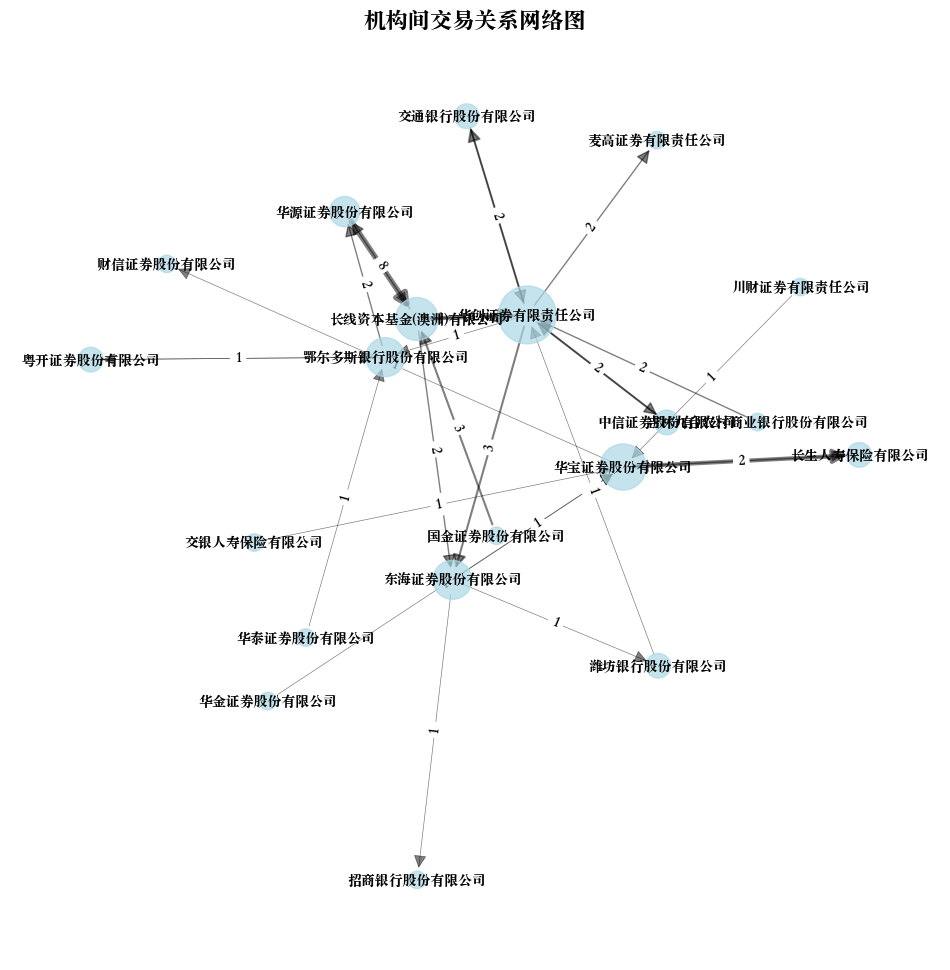

<Figure size 640x480 with 0 Axes>

In [366]:
def create_institution_network(data):
    """
    创建机构间交易关系图
    参数: data: DataFrame, 包含买卖方机构信息的交易数据
    返回: G: networkx.Graph, 机构间交易关系图
    """
    # 创建无向图
    # G = nx.Graph()

    # 改用有向图
    G = nx.DiGraph()    

    
    # 统计机构间的交易次数
    institution_pairs = data.groupby(['byr_instn_cn_full_nm', 'slr_instn_cn_full_nm']).size().reset_index()
    institution_pairs.columns = ['buyer', 'seller', 'trade_count']

    # 统计交易员之间的交易次数
    # institution_trader_pairs = data.groupby(['byr_instn_cn_full_nm', 'byr_trdr_nm', 'slr_instn_cn_full_nm', 'slr_trdr_nm']).size().reset_index()
    # institution_trader_pairs.columns = ['buyer', 'buyer_trader', 'seller', 'seller_trader', 'trade_count']
    
    # 添加节点和边
    for _, row in institution_pairs.iterrows():
        buyer, seller = row['buyer'], row['seller']
        # buyer, seller = row['buyer'] + '-' + row['buyer_trader'], row['seller'] + '-' + row['seller_trader']

        trade_count = row['trade_count']
        
        # 添加节点
        G.add_node(buyer)
        G.add_node(seller)
        
        # 添加边，权重为交易次数
        G.add_edge(buyer, seller, weight=trade_count)
    
    return G, institution_pairs

def plot_institution_network(G, min_edge_weight=1, figsize=(12, 12)):
    """
    绘制机构间交易关系图
    参数: G: networkx.Graph, 机构间交易关系图
        min_edge_weight: int, 最小边权重（交易次数阈值）
        figsize: tuple, 图形大小
    """
    # 创建新图仅包含满足权重阈值的边
    H = G.copy()
    edges_to_remove = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] < min_edge_weight]
    H.remove_edges_from(edges_to_remove)
    
    # 设置绘图参数
    plt.figure(figsize=figsize)
    
    # 计算节点大小（基于度中心性）
    node_size = [3000 * nx.degree_centrality(H)[node] for node in H.nodes()]
    # node_size = 1000  # 统一节点大小
    
    # 计算边的宽度（基于权重）
    edge_width = [0.5 * d['weight'] for u, v, d in H.edges(data=True)]
    
    # layout布局
    # pos = nx.kamada_kawai_layout(H)
    pos = nx.spring_layout( # 力导向布局
        H,
        k=2,           # 节点间斥力因子，越大节点间距越大
        iterations=100,  # 迭代次数，越多布局越稳定
        seed=1       # 固定随机种子以获得稳定布局
    )
    
    
    # 绘制网络
    nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(H, pos, width=edge_width, alpha=0.5, arrows=True, arrowsize=20)
    nx.draw_networkx_labels(H, pos, font_size=10)

    # edge_labels = nx.get_edge_attributes(H, 'weight')
    # nx.draw_networkx_edge_labels(H, pos,
    #                             edge_labels=edge_labels,
    #                             font_size=10)
    
    # 添加标题和说明
    plt.title('机构间交易关系网络图', fontsize=16)
    plt.axis('off')
    
    return H

# 创建并绘制网络
G, institution_pairs = create_institution_network(filter_data)

# 打印基本统计信息
print(f"总机构数: {G.number_of_nodes()}")
print(f"总连接数: {G.number_of_edges()}")

# 绘制网络图（可以调整min_edge_weight来控制显示的边数量）
H = plot_institution_network(G, min_edge_weight=0)
plt.show()

# 如果需要保存图片
plt.savefig('institution_network.png', dpi=300, bbox_inches='tight')


找到的交易环路：

环路 1:
潍坊银行股份有限公司 -> 华创证券有限责任公司 (交易次数: 1)
华创证券有限责任公司 -> 东海证券股份有限公司 (交易次数: 3)
东海证券股份有限公司 -> 潍坊银行股份有限公司 (交易次数: 1)

环路 2:
潍坊银行股份有限公司 -> 华创证券有限责任公司 (交易次数: 1)
华创证券有限责任公司 -> 鄂尔多斯银行股份有限公司 (交易次数: 1)
鄂尔多斯银行股份有限公司 -> 华源证券股份有限公司 (交易次数: 2)
华源证券股份有限公司 -> 长线资本基金(澳洲)有限公司 (交易次数: 8)
长线资本基金(澳洲)有限公司 -> 东海证券股份有限公司 (交易次数: 2)
东海证券股份有限公司 -> 潍坊银行股份有限公司 (交易次数: 1)

环路 3:
潍坊银行股份有限公司 -> 华创证券有限责任公司 (交易次数: 1)
华创证券有限责任公司 -> 长线资本基金(澳洲)有限公司 (交易次数: 2)
长线资本基金(澳洲)有限公司 -> 东海证券股份有限公司 (交易次数: 2)
东海证券股份有限公司 -> 潍坊银行股份有限公司 (交易次数: 1)

环路 4:
粤开证券股份有限公司 -> 鄂尔多斯银行股份有限公司 (交易次数: 1)
鄂尔多斯银行股份有限公司 -> 粤开证券股份有限公司 (交易次数: 1)

环路 5:
鄂尔多斯银行股份有限公司 -> 华源证券股份有限公司 (交易次数: 2)
华源证券股份有限公司 -> 长线资本基金(澳洲)有限公司 (交易次数: 8)
长线资本基金(澳洲)有限公司 -> 华创证券有限责任公司 (交易次数: 6)
华创证券有限责任公司 -> 鄂尔多斯银行股份有限公司 (交易次数: 1)

环路 6:
长线资本基金(澳洲)有限公司 -> 华创证券有限责任公司 (交易次数: 6)
华创证券有限责任公司 -> 长线资本基金(澳洲)有限公司 (交易次数: 2)

环路 7:
长线资本基金(澳洲)有限公司 -> 华源证券股份有限公司 (交易次数: 2)
华源证券股份有限公司 -> 长线资本基金(澳洲)有限公司 (交易次数: 8)

环路 8:
交通银行股份有限公司 -> 华创证券有限责任公司 (交易次数: 2)
华创证券有限责任公司 -> 交通银行股份有限公司 (交易次数: 3)

环路 9:


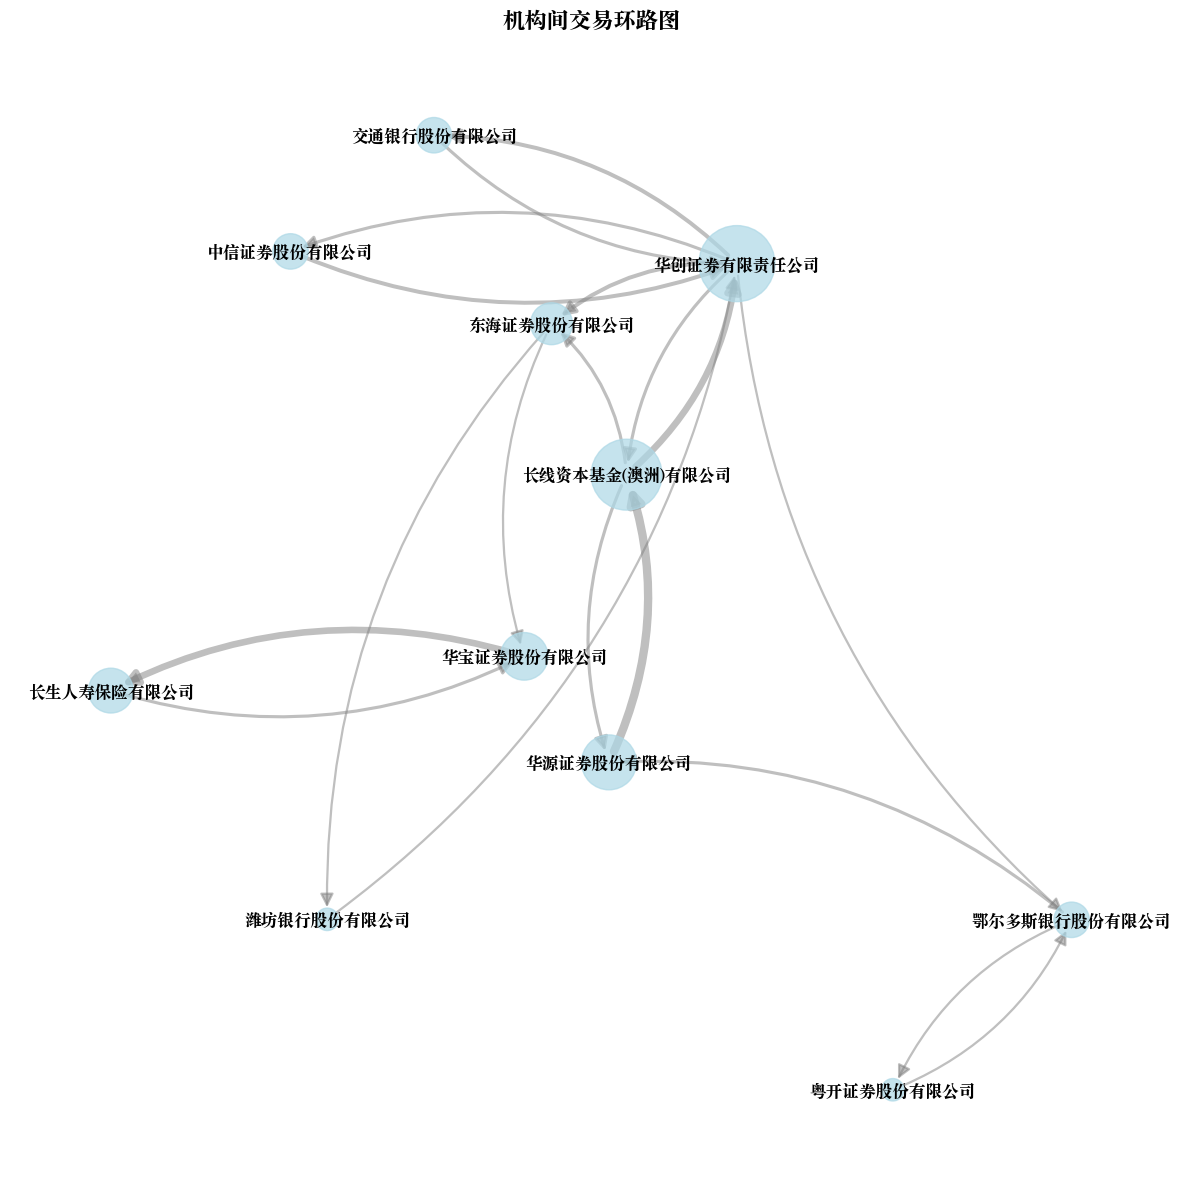

In [369]:
# 仅保留环路
def find_cycles(G):
    """找出图中的所有环路节点"""
    cycle_nodes = set()
    
    # 找出所有简单环路
    try:
        cycles = list(nx.simple_cycles(G))
        for cycle in cycles:
            cycle_nodes.update(cycle)
    except:
        print("警告：在查找环路时出现错误")
        return set()
    
    return cycle_nodes


def plot_institution_network(G, min_edge_weight=1, figsize=(12, 12)):
    """绘制机构间交易关系图（只显示环路上的节点）"""
    H = G.copy()
    
    # 移除低权重边
    edges_to_remove = [(u, v) for u, v, d in H.edges(data=True) 
                      if d['weight'] < min_edge_weight]
    H.remove_edges_from(edges_to_remove)
    
    # 找出环路上的节点
    cycle_nodes = find_cycles(H)
    
    if not cycle_nodes:
        print("未找到环路节点")
        return H
    
    # 只保留环路上的节点
    nodes_to_remove = set(H.nodes()) - cycle_nodes
    H.remove_nodes_from(nodes_to_remove)
    
    if len(H.nodes()) == 0:
        print("移除非环路节点后图为空")
        return H
    
    plt.figure(figsize=figsize)
    
    # 使用force-directed布局
    pos = nx.spring_layout(H, k=3, iterations=100, seed=42)
    
    # 计算节点大小
    in_degree = dict(H.in_degree(weight='weight'))
    out_degree = dict(H.out_degree(weight='weight'))
    total_degree = {node: in_degree.get(node, 0) + out_degree.get(node, 0) 
                   for node in H.nodes()}
    max_degree = max(total_degree.values()) if total_degree else 1
    node_size = [3000 * (total_degree[node] / max_degree) for node in H.nodes()]
    
    # 计算边的宽度
    edge_weights = [d['weight'] for u, v, d in H.edges(data=True)]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_width = [1 + 5 * (d['weight'] / max_weight) for u, v, d in H.edges(data=True)]
    
    # 绘制节点
    nx.draw_networkx_nodes(H, pos,
                          node_size=node_size,
                          node_color='lightblue',
                          alpha=0.7)
    
    # 绘制边
    nx.draw_networkx_edges(H, pos,
                          width=edge_width,
                          alpha=0.5,
                          arrows=True,
                          arrowsize=20,
                          edge_color='gray',
                          connectionstyle='arc3,rad=0.2')
    
    # 添加标签
    nx.draw_networkx_labels(H, pos, font_size=12)
    
    # 添加边的权重标签
    # edge_labels = nx.get_edge_attributes(H, 'weight')
    # nx.draw_networkx_edge_labels(H, pos,
    #                             edge_labels=edge_labels,
    #                             font_size=10)

    
    plt.title('机构间交易环路图', fontsize=16)
    plt.axis('off')
    
    # 打印具体的环路
    print("\n找到的交易环路：")
    cycles = list(nx.simple_cycles(H))
    for i, cycle in enumerate(cycles, 1):
        print(f"\n环路 {i}:")
        for j in range(len(cycle)):
            current = cycle[j]
            next_node = cycle[(j + 1) % len(cycle)]
            weight = H[current][next_node]['weight']
            print(f"{current} -> {next_node} (交易次数: {weight})")
    
    return H

# 创建并绘制网络
G, institution_pairs = create_institution_network(filter_data)

# 绘制只包含环路的网络图
H = plot_institution_network(G, min_edge_weight=0, figsize=(15, 15))
plt.show()